In [1]:
from lineage_motif.plot import *
from lineage_motif.resample import *
from lineage_motif.simulate import *

In [2]:
base=0.485
inv_base=0.8-base
increment=-0.02

transition_matrix = np.array([[0.2, inv_base, 0, 0, 0, 0, base, 0, 0, 0, 0, 0],
                              [0, 0.2, inv_base+increment, 0, 0, 0, 0, base-increment, 0, 0, 0, 0],
                              [0, 0, 0.2, inv_base+increment*2, 0, 0, 0, 0, base-increment*2, 0, 0, 0],
                              [0, 0, 0, 0.2, inv_base+increment*3, 0, 0, 0, 0, base-increment*3, 0, 0],
                              [0, 0, 0, 0, 0.2, inv_base+increment*4, 0, 0, 0, 0, base-increment*4, 0],
                              [0, 0, 0, 0, 0, 0.2, 0, 0, 0, 0, 0, 0.8],
                              [0]*12,
                              [0]*12,
                              [0]*12,
                              [0]*12,
                              [0]*12,
                              [0]*12,])

In [3]:
all_trees_unsorted = [simulate_tree(transition_matrix, starting_progenitor='a', labels='abcdefABCDEF') for i in range(5000)]
all_trees_sorted = [sort_align_tree(i) for i in all_trees_unsorted]
all_trees_sorted[:10]

['(A,(B,(B,(C,(D,D)))))',
 '(A,(B,(C,C)))',
 '(((C,C),(B,((C,(D,(E,(E,E)))),(B,B)))),A)',
 '(A,A)',
 '(((((D,((E,E),(F,(F,F)))),(D,D)),(C,(D,(E,E)))),(C,(C,(C,C)))),A)',
 '((B,B),(B,(B,(B,(C,C)))))',
 '((B,(B,(B,((C,((D,(D,D)),(E,(E,E)))),(C,C))))),A)',
 '(A,A)',
 '(A,(B,(B,(C,(D,(D,D))))))',
 '(A,A)']

In [5]:
(doublet_dict, 
 cell_fates, 
 dfs_c_doublet) = resample_trees_doublets(all_trees_sorted, 
                                           num_resamples=1000, 
                                           replacement_bool=True, 
                                           cell_fates='auto',
                                           calc_expected=False
                                           )

100%|██████████| 1000/1000 [02:27<00:00,  6.77it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [13]:
def make_df_all_cells(all_trees_sorted, cell_dict, resample, labels_bool=False):
    """Makes a DataFrame of all cells in the set of trees.
    
    Args:
        all_trees_sorted (list): List where each entry is a string representing a tree in NEWICK format. 
            Trees are sorted using the `sort_align_tree` function.
        cell_dict (dict): Keys are cell types, values are integers.
        resample (int): Resample number.
        labels_bool (bool, optional): If True, then index of resulting DataFrame uses `doublet_dict` keys.
            
    Returns:
        df_doublets (DataFrame): Rows are cell types, column is resample number.
    """
    all_cells = _flatten_all_cells(all_trees_sorted)
    all_cells_resample_index = [cell_dict[i] for i in all_cells]
    df_all_cells = pd.DataFrame.from_dict(Counter(all_cells_resample_index), orient='index', columns=[f"{resample}"])
    if labels_bool == True:
        df_all_cells = df_all_cells.rename({v: k for k, v in cell_dict.items()})
    return df_all_cells

def make_cell_dict(cell_fates):
    """Makes a dictionary of all possible cell fates.
    
    Args:
        cell_fates (list): List with each entry as a cell fate.
    
    Returns:
        cell_dict (dict): Keys are cell types, values are integers.
    """
    
    cell_dict = {}
    for i, j in enumerate(cell_fates):
        cell_dict[j] = i
        
    return cell_dict

def _flatten_all_cells(all_trees_sorted):
    """Makes a list of all cells in the set of trees.
    
    Args:
        all_trees_sorted (list): List where each entry is a string representing a tree in NEWICK format. 
            Trees are sorted using the `sort_align_tree` function.
    
    Returns:
        all_cells (list): List with each entry as a cell (string).
    """
    
    all_cells = []
    for i in all_trees_sorted:
        for j in re.findall("[A-Za-z0-9]+", i):
            all_cells.extend(j)
    return all_cells

In [14]:
all_cells = make_df_all_cells(all_trees_sorted, make_cell_dict(cell_fates), 'observed', True)
all_cells/all_cells.sum()

observed
A  0.163934
B  0.179424
C  0.179565
D  0.167120
E  0.149069
F  0.160888

In [15]:
cell_color_dict = make_color_dict(cell_fates, ['#F89A3A', 
                                                    '#9C80B8', 
                                                    '#F071AB', 
                                                    '#F0E135',
                                                    '#5FC0D4', 
                                                    '#7EC352',
                                                    ])

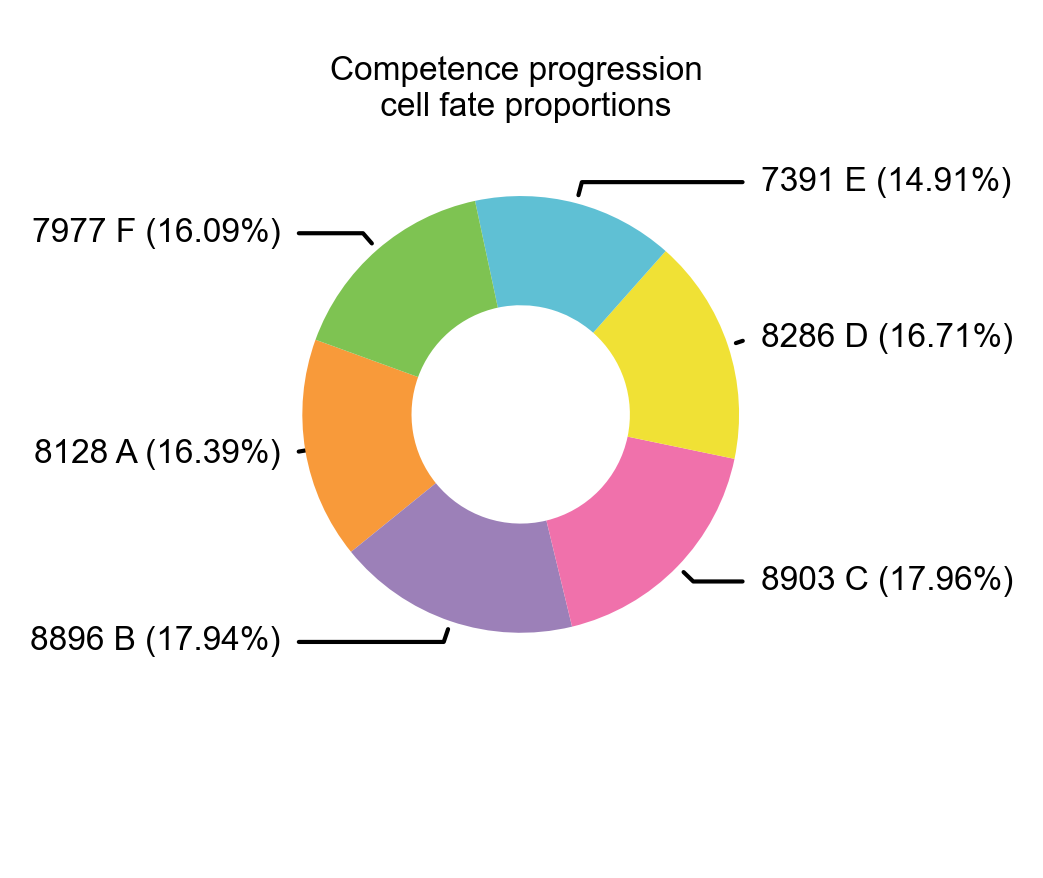

In [16]:
fig, ax = pyplot.subplots(1, 1, figsize=(3.25,3))
i=0

dict_all_cells_true = all_cells.sort_index()['observed'].to_dict()
cells = np.array([k for k, v in dict_all_cells_true.items()])
cell_counts = np.array([v for k, v in dict_all_cells_true.items()])
norm_cell_counts = np.round(cell_counts/cell_counts.sum()*100, 2)

norm_cell_counts_str = [f' ('+str(percent)+'%)' for ind, percent in enumerate(norm_cell_counts)]
annot = [str(count)+' '+cell+suffix for count, cell, suffix in zip(cell_counts, cells, norm_cell_counts_str)]

data = dict_all_cells_true.values()

colors_to_use = cell_color_dict.values()
wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-200, colors=colors_to_use, )

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for b, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(annot[b], xy=(x, y), xytext=(1.1*np.sign(x), 1.1*y),
                horizontalalignment=horizontalalignment, **kw, **{'fontname':'Arial', 'size':8})

ax.set_title(f"Competence progression \n cell fate proportions", y=1, **{'fontname':'Arial', 'size':8})

pyplot.tight_layout(h_pad=-8, w_pad=4)

# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
pyplot.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
pyplot.grid(False)
#pyplot.title("Cell fate proportions across zebrafish retina regions", y=0, **{'fontname':'Arial', 'size':8}, fontweight="bold")

image_format = 'svg'

#pyplot.savefig(f"comp_prog_cell_fate_proportions_v02.{image_format}", dpi=300, bbox_inches="tight")

In [19]:
(doublet_dict,
 df_true_melt_subset_doublet, 
 df_melt_subset_doublet, 
 df_melt_100resamples_subset_doublet, 
 df_null_zscores_i_c_melt_subset_doublet, 
 df_null_zscores_i_c_melt_100resamples_subset_doublet) = dfs_for_plotting(dfs_c_doublet, 
                                                                       1000, 
                                                                       doublet_dict, 
                                                                       cutoff=None, 
                                                                       num_null=100,
                                                                       use_expected=False)

100%|██████████| 100/100 [00:01<00:00, 93.80it/s]


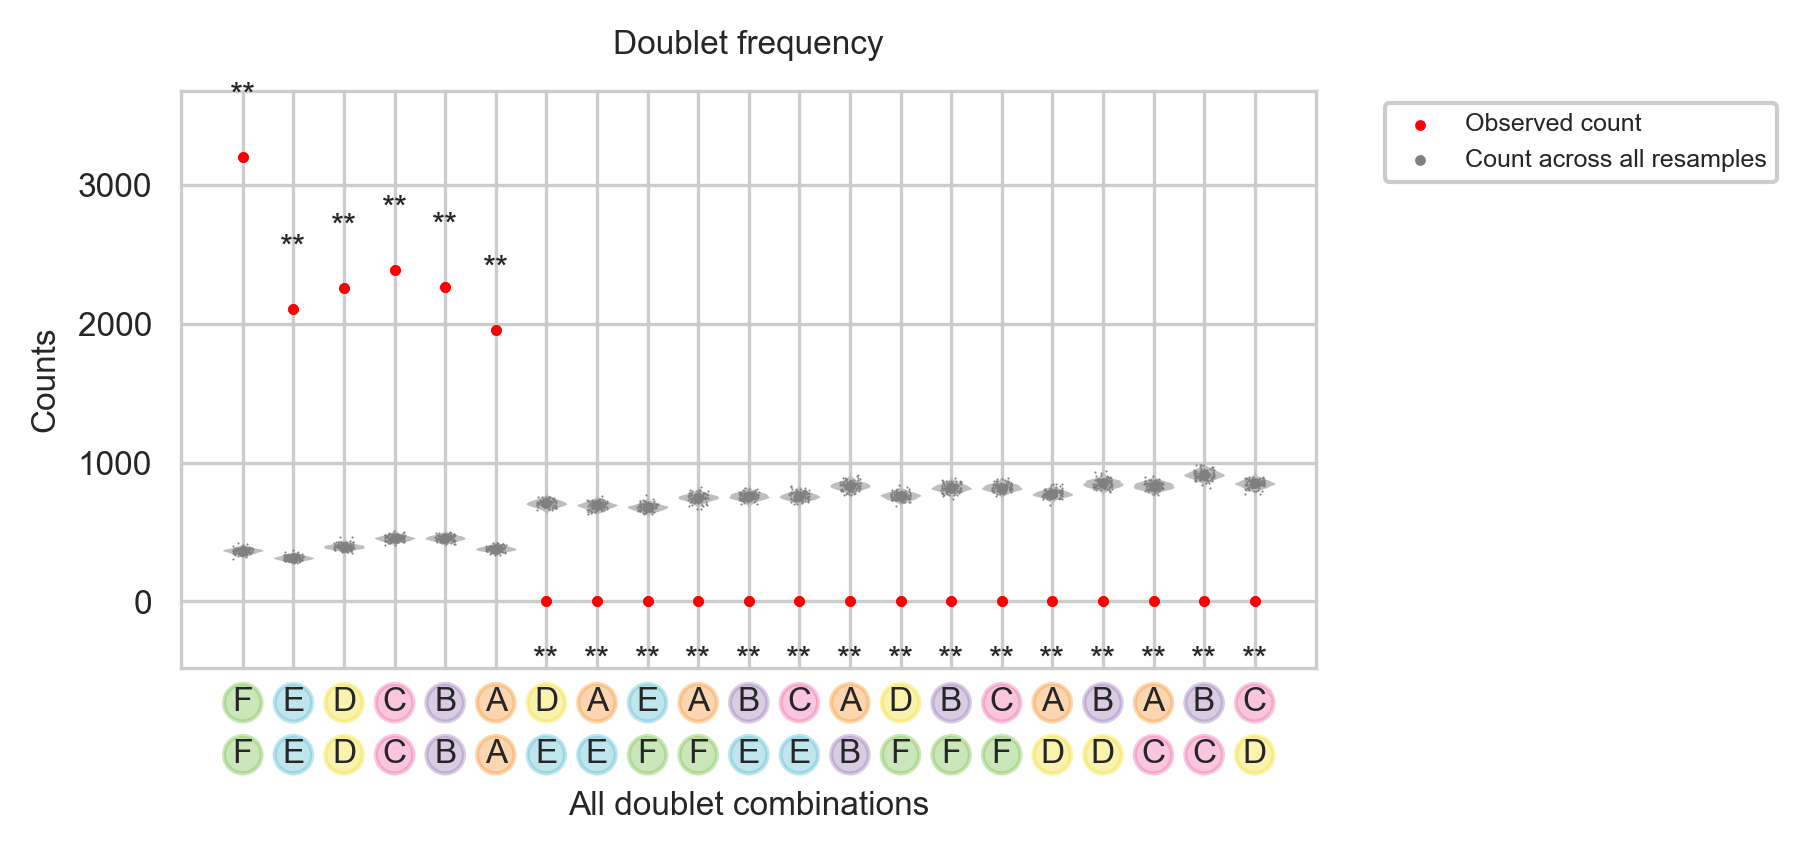

In [20]:
plot_frequency('doublet', 
                    df_true_melt_subset_doublet, 
                    df_melt_subset_doublet, 
                    df_melt_100resamples_subset_doublet, 
                    cell_color_dict,
                    use_expected=False,
                    fdr_type='fdr_tsbh',
                    cutoff=None, 
                    title='auto',
                    multiple_datasets=False,
                    legend_bool=True, 
                    legend_pos='outside',
                    save=False, 
                    image_format='png',
                    dpi=300,
                    image_save_path=None)

In [21]:
plot_deviation('doublet', 
                    df_true_melt_subset_doublet, 
                    df_null_zscores_i_c_melt_subset_doublet, 
                    df_null_zscores_i_c_melt_100resamples_subset_doublet, 
                    cell_color_dict,
                    fdr_type='fdr_tsbh',
                    cutoff=None, 
                    title='auto',
                    multiple_datasets=False,
                    num_null=100,
                    legend_bool=True,
                    legend_pos='outside',
                    save=False, 
                    image_format='svg',
                    dpi=300,
                    image_save_path='comp_prog_dev_doublet_v02')

TypeError: plot_deviation() got an unexpected keyword argument 'num_null'

In [ ]:
(triplet_dict, 
 cell_fates, 
 dfs_c_triplet) = resample_trees_triplets(all_trees_sorted, 
                                           num_resamples=1000, 
                                           replacement_bool=True, 
                                           cell_fates='auto',
                                           calc_expected=False
                                           )

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

In [ ]:
(df_true_melt_subset_triplet, 
 df_melt_subset_triplet, 
 df_melt_100resamples_subset_triplet, 
 df_null_zscores_i_c_melt_subset_triplet, 
 df_null_zscores_i_c_melt_100resamples_subset_triplet) = dfs_for_plotting(dfs_c_triplet, 
                                                                       1000, 
                                                                       triplet_dict, 
                                                                       cutoff=15, 
                                                                       num_null=100,
                                                                       use_expected=False,)

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

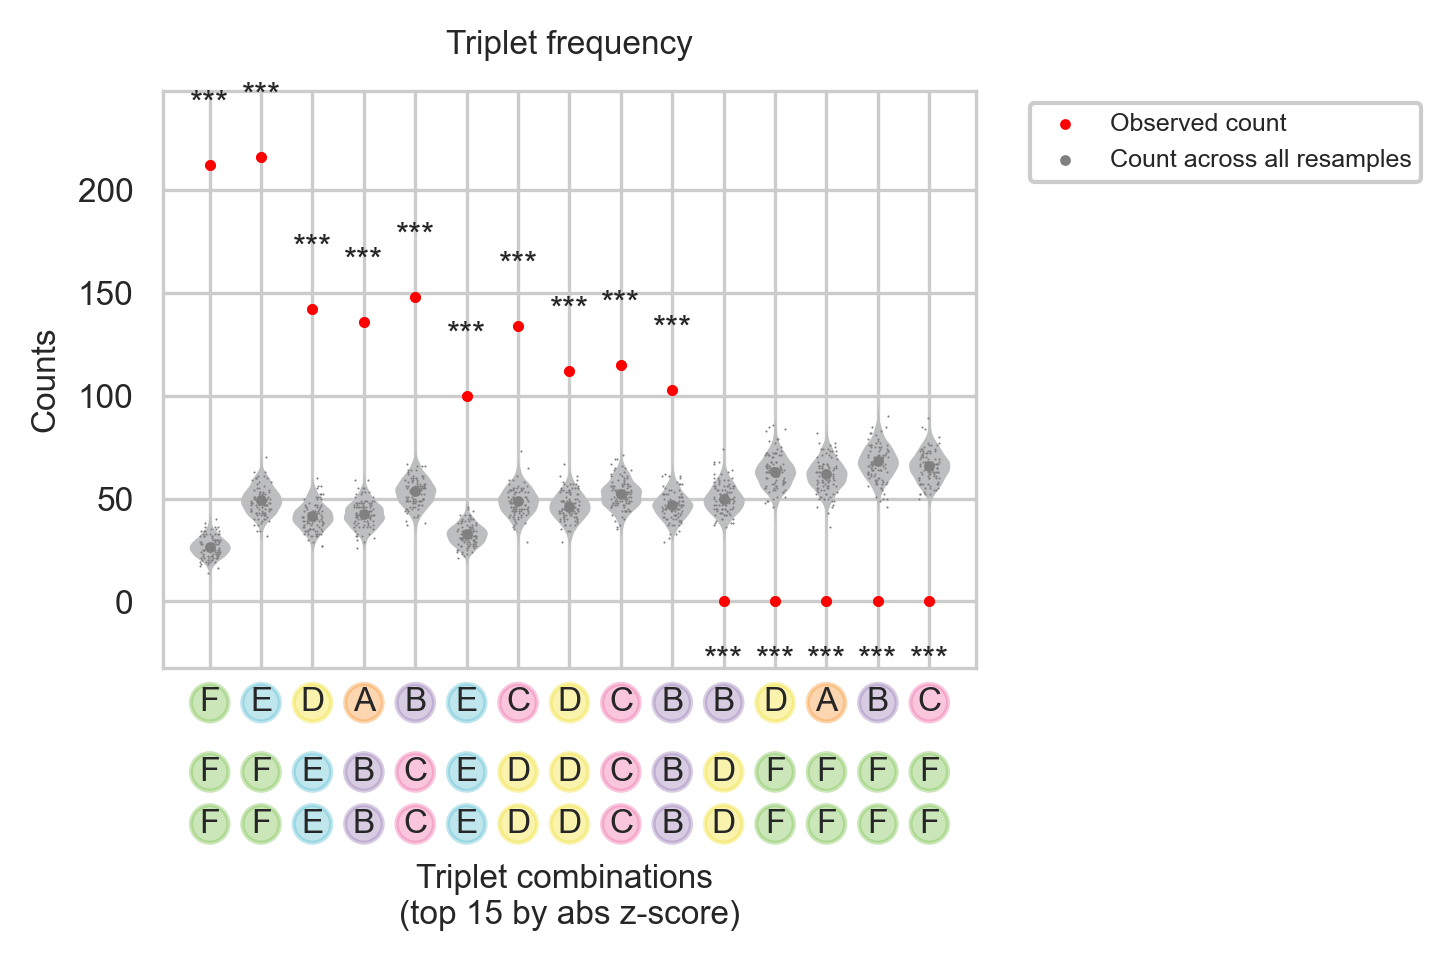

In [ ]:
plot_frequency('triplet', 
                    df_true_melt_subset_triplet, 
                    df_melt_subset_triplet, 
                    df_melt_100resamples_subset_triplet, 
                    cell_color_dict,
                    use_expected=False,
                    fdr_type='fdr_tsbh',
                    cutoff=15, 
                    title='auto',
                    multiple_datasets=False,
                    legend_bool=True, 
                    legend_pos='outside',
                    save=False, 
                    image_format='png',
                    dpi=300,
                    image_save_path=None)

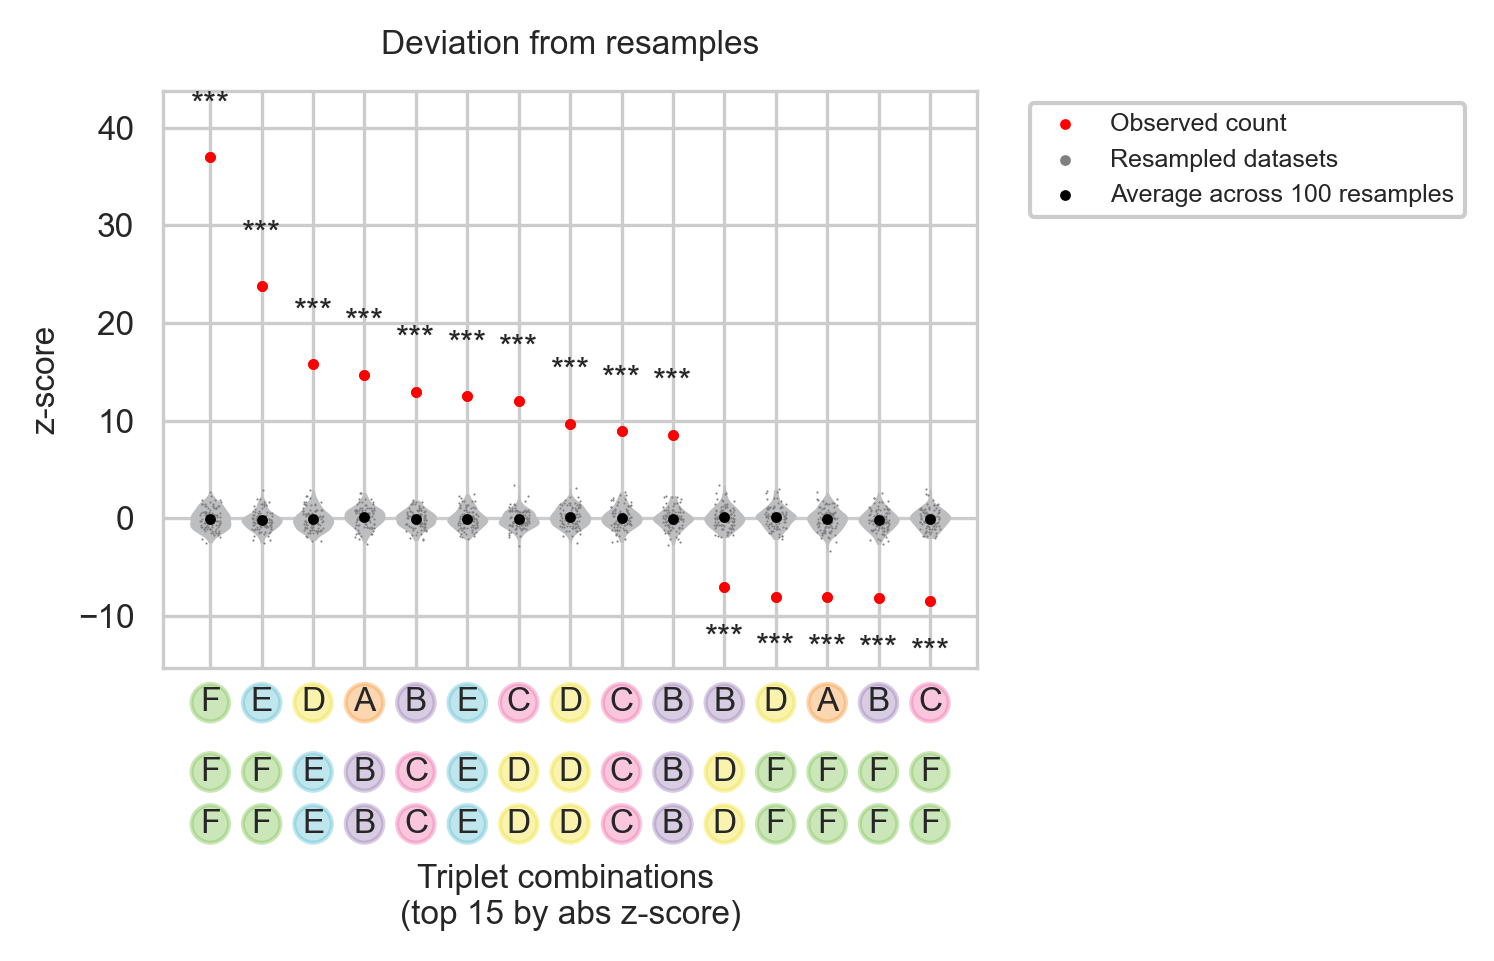

In [ ]:
plot_deviation('triplet', 
                    df_true_melt_subset_triplet, 
                    df_null_zscores_i_c_melt_subset_triplet, 
                    df_null_zscores_i_c_melt_100resamples_subset_triplet, 
                    cell_color_dict,
                    fdr_type='fdr_tsbh',
                    cutoff=15, 
                    title='auto',
                    multiple_datasets=False,
                    num_null=100,
                    legend_bool=True,
                    legend_pos='outside',
                    save=False, 
                    image_format='svg',
                    dpi=300,
                    image_save_path='comp_prog_dev_triplet_v02')

In [ ]:
(asym_quartet_dict, 
 cell_fates, 
 dfs_c_asym_quartet) = resample_trees_asym_quartets(all_trees_sorted, 
                                           num_resamples=1000, 
                                           replacement_bool=True, 
                                           cell_fates='auto',
                                           calc_expected=False
                                           )

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/690 [00:00<?, ?it/s]

In [ ]:
(df_true_melt_subset_asym_quartet, 
 df_melt_subset_asym_quartet, 
 df_melt_100resamples_subset_asym_quartet, 
 df_null_zscores_i_c_melt_subset_asym_quartet, 
 df_null_zscores_i_c_melt_100resamples_subset_asym_quartet) = dfs_for_plotting(dfs_c_asym_quartet, 
                                                                       1000, 
                                                                       asym_quartet_dict, 
                                                                       cutoff=25, 
                                                                       num_null=100,
                                                                       use_expected=False,)

  0%|          | 0/756 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

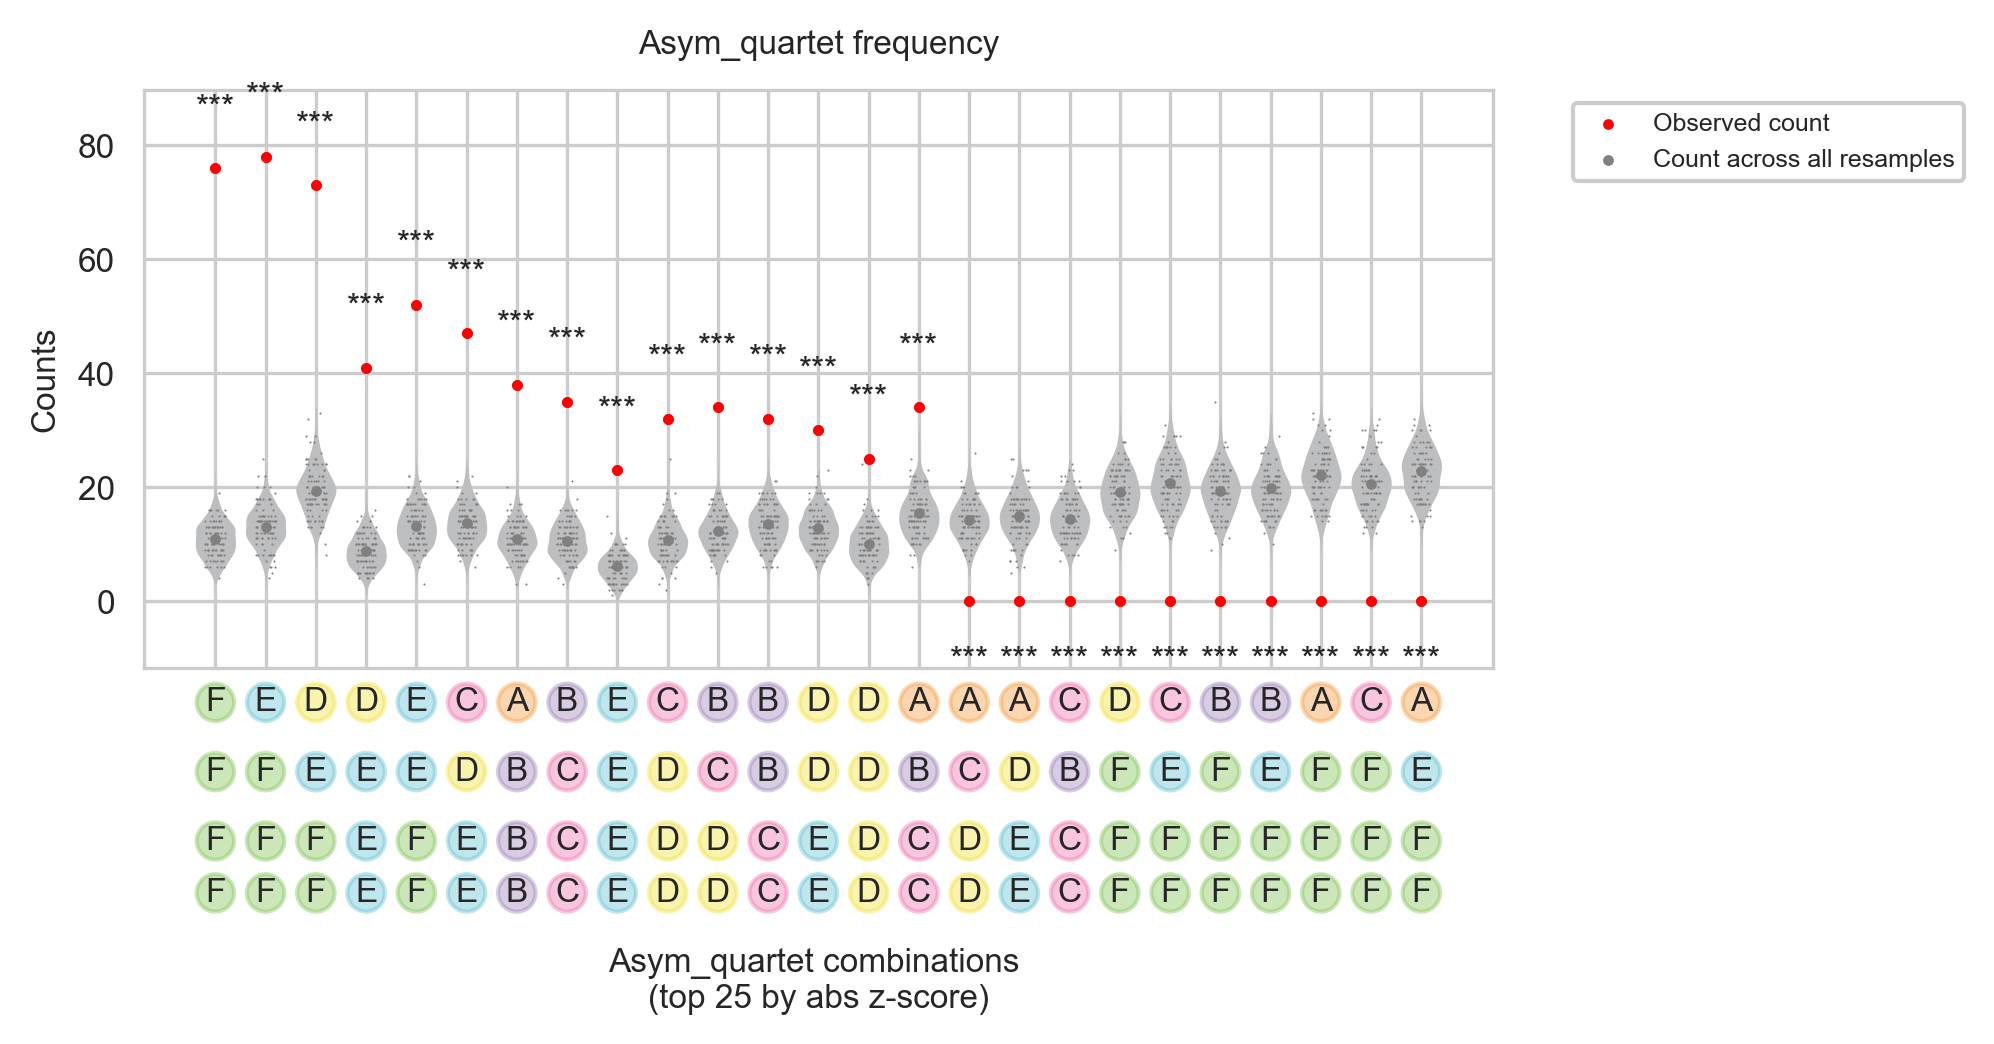

In [ ]:
plot_frequency('asym_quartet', 
                    df_true_melt_subset_asym_quartet, 
                    df_melt_subset_asym_quartet, 
                    df_melt_100resamples_subset_asym_quartet, 
                    cell_color_dict,
                    use_expected=False,
                    fdr_type='fdr_tsbh',
                    cutoff=40, 
                    title='auto',
                    multiple_datasets=False,
                    legend_bool=True, 
                    legend_pos='outside',
                    save=False, 
                    image_format='png',
                    dpi=300,
                    image_save_path=None)

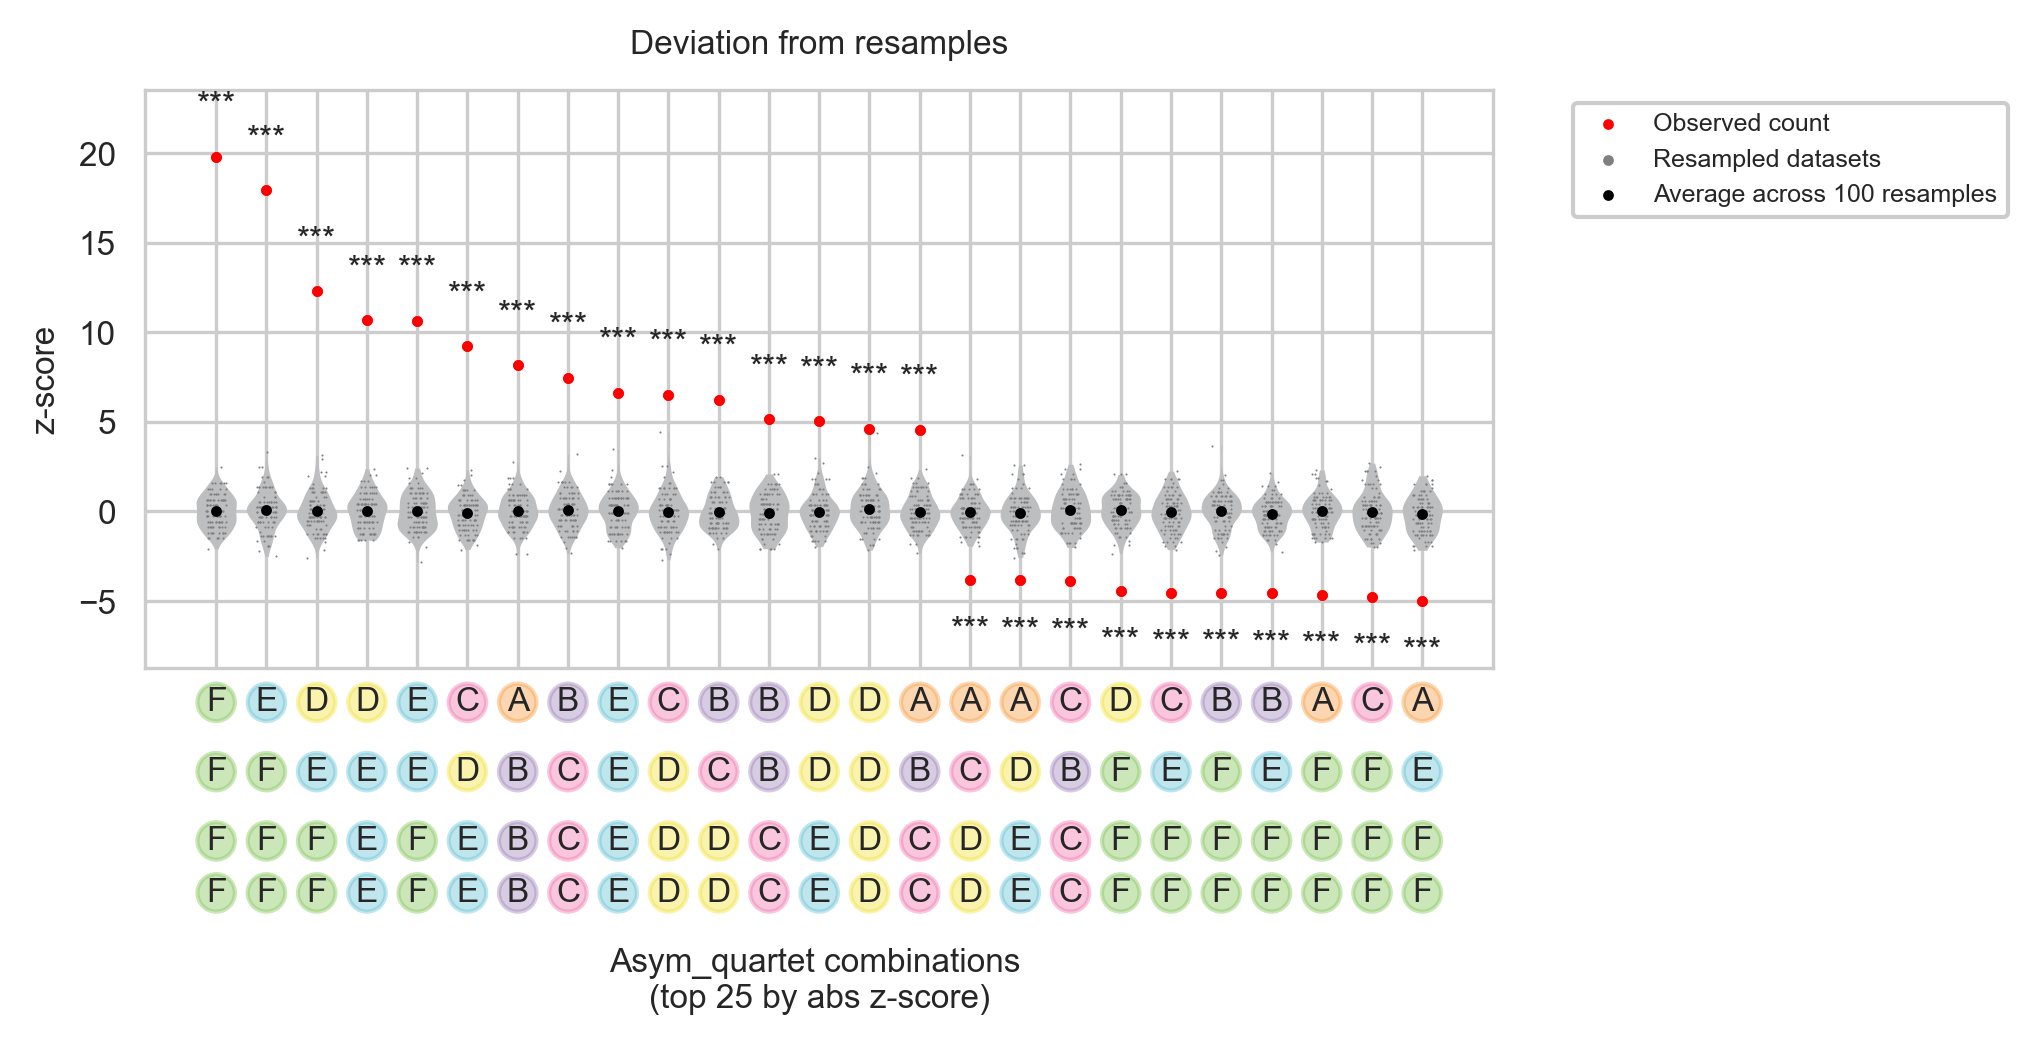

In [ ]:
plot_deviation('asym_quartet', 
                    df_true_melt_subset_asym_quartet, 
                    df_null_zscores_i_c_melt_subset_asym_quartet, 
                    df_null_zscores_i_c_melt_100resamples_subset_asym_quartet, 
                    cell_color_dict,
                    fdr_type='fdr_tsbh',
                    cutoff=40, 
                    title='auto',
                    multiple_datasets=False,
                    num_null=100,
                    legend_bool=True,
                    legend_pos='outside',
                    save=False, 
                    image_format='svg',
                    dpi=300,
                    image_save_path='comp_prog_dev_asym_quartet_v02')

In [ ]:
(asym_quintet_dict, 
 cell_fates, 
 dfs_c_asym_quintet) = resample_trees_asym_quintets(all_trees_sorted, 
                                           num_resamples=1000, 
                                           replacement_bool=True, 
                                           cell_fates='auto',
                                           calc_expected=False
                                           )

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/4416 [00:00<?, ?it/s]

In [ ]:
(df_true_melt_subset_asym_quintet, 
 df_melt_subset_asym_quintet, 
 df_melt_100resamples_subset_asym_quintet, 
 df_null_zscores_i_c_melt_subset_asym_quintet, 
 df_null_zscores_i_c_melt_100resamples_subset_asym_quintet) = dfs_for_plotting(dfs_c_asym_quintet, 
                                                                       1000, 
                                                                       asym_quintet_dict, 
                                                                       cutoff=25, 
                                                                       num_null=5,
                                                                       use_expected=False,)

  0%|          | 0/4536 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

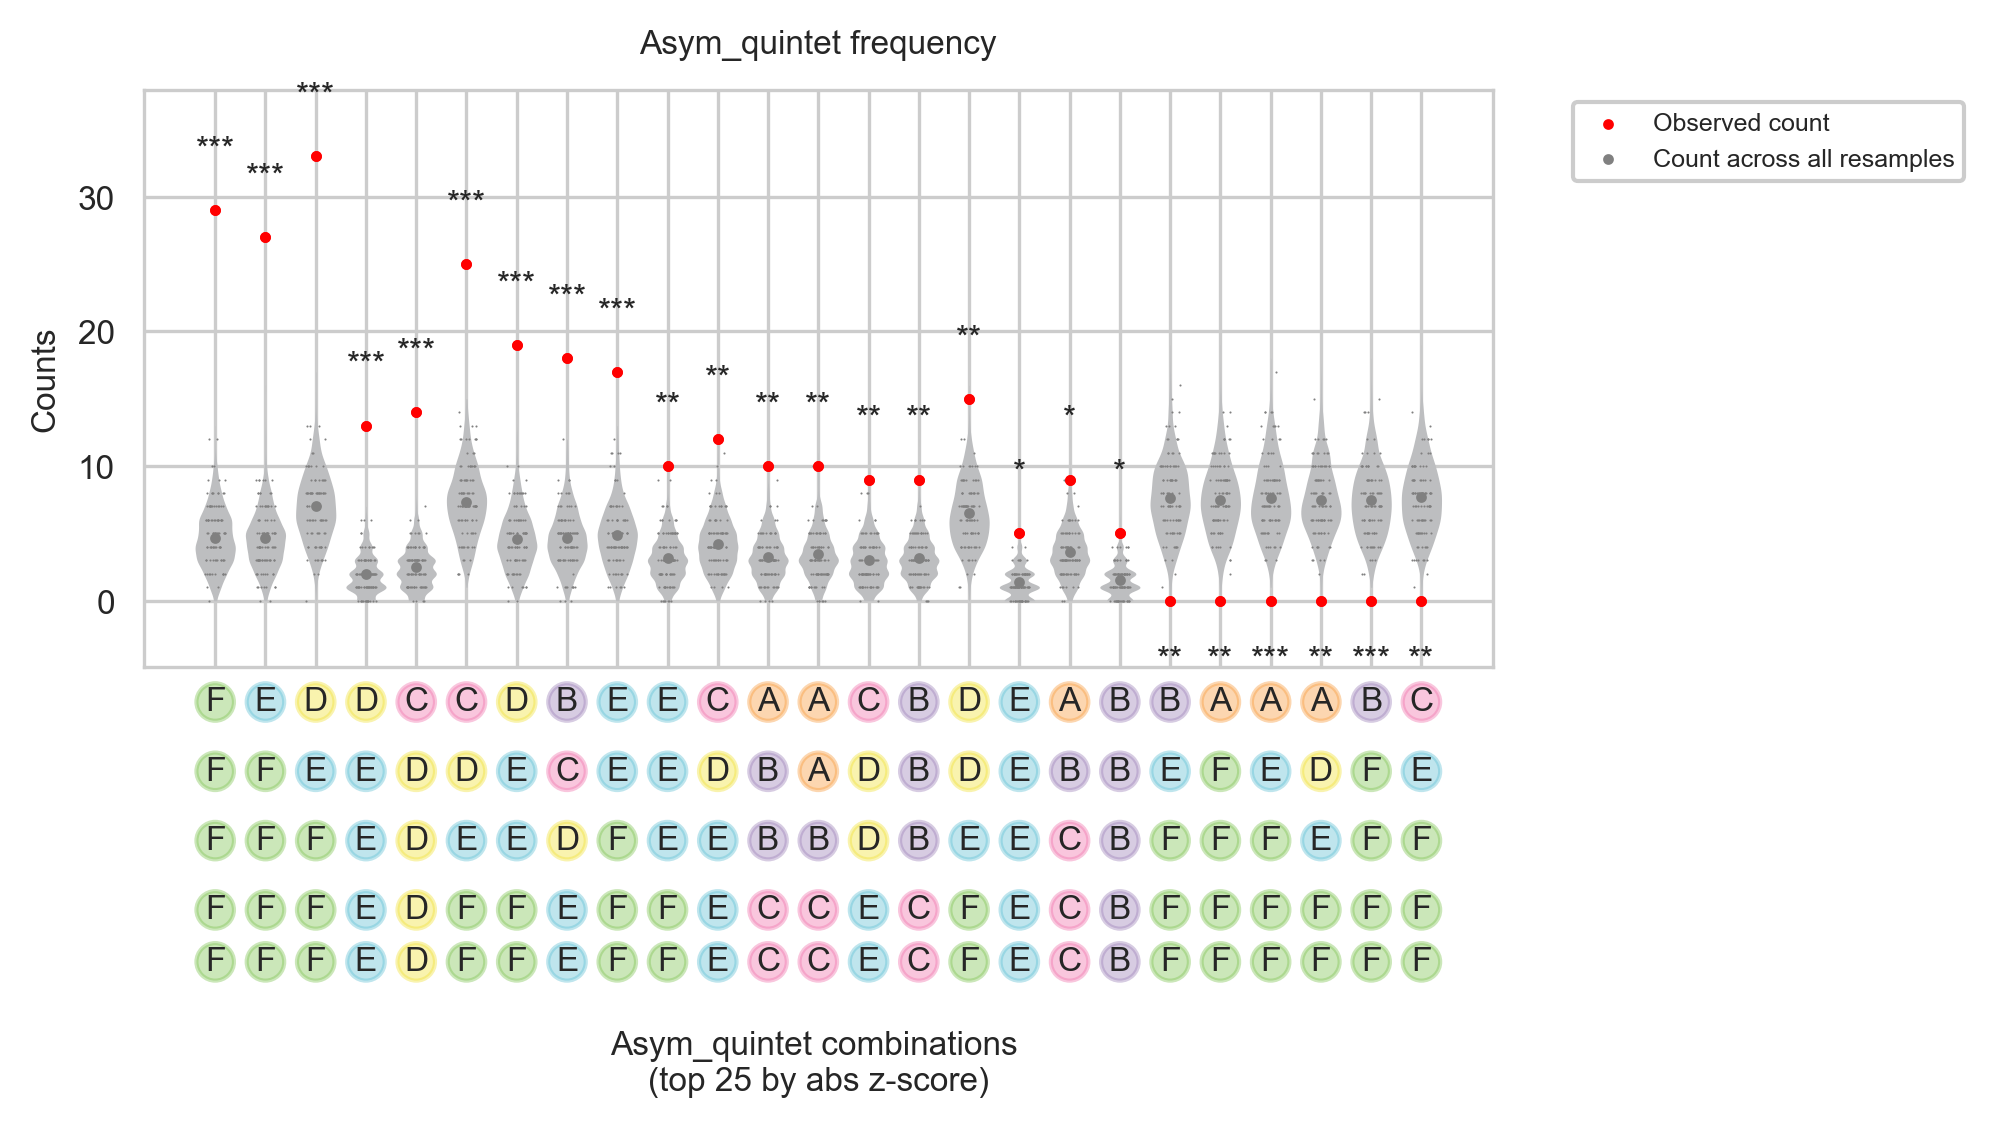

In [ ]:
plot_frequency('asym_quintet', 
                    df_true_melt_subset_asym_quintet, 
                    df_melt_subset_asym_quintet, 
                    df_melt_100resamples_subset_asym_quintet, 
                    cell_color_dict,
                    use_expected=False,
                    fdr_type='fdr_tsbh',
                    cutoff=40, 
                    title='auto',
                    multiple_datasets=False,
                    legend_bool=True, 
                    legend_pos='outside',
                    save=False, 
                    image_format='png',
                    dpi=300,
                    image_save_path=None)

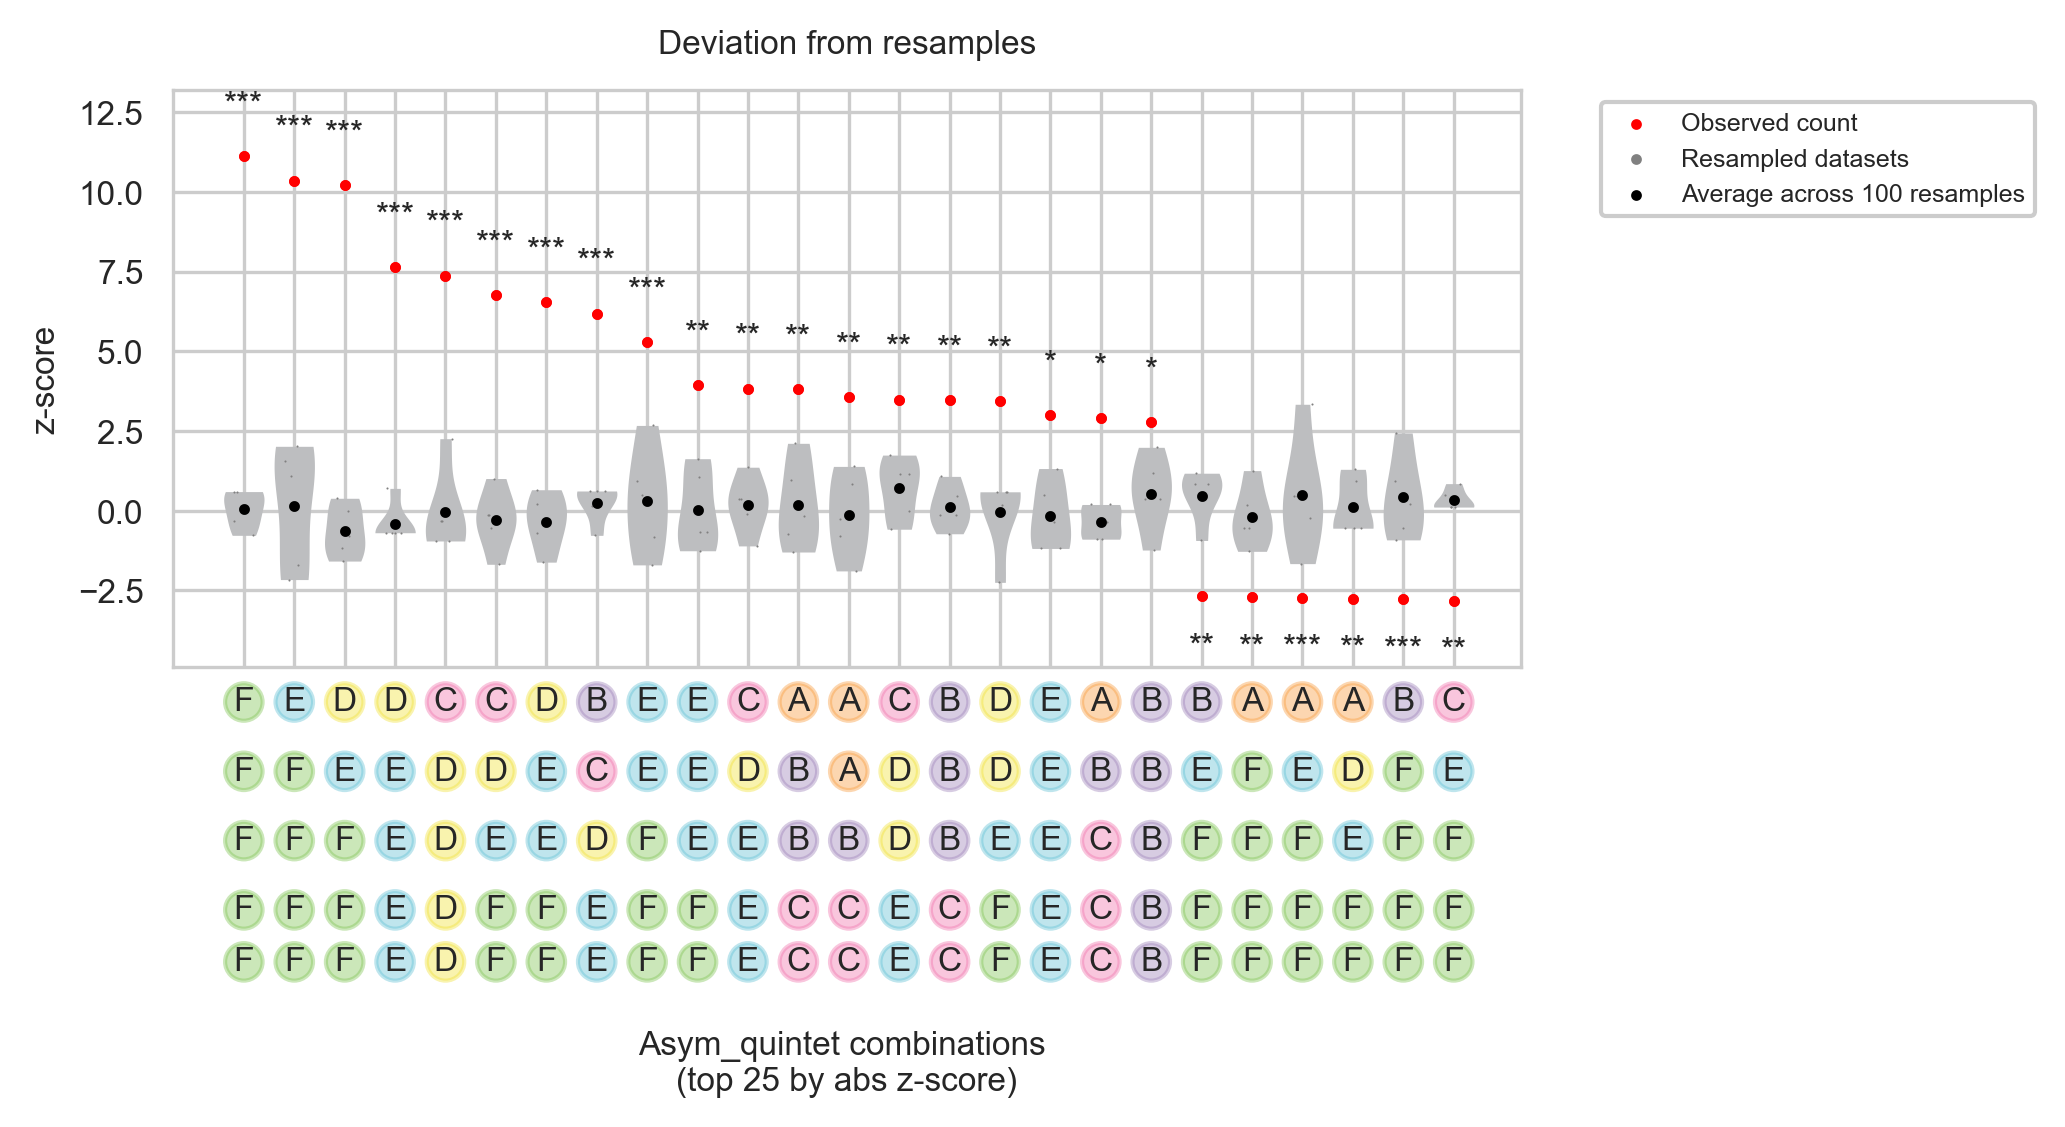

In [ ]:
plot_deviation('asym_quintet', 
                    df_true_melt_subset_asym_quintet, 
                    df_null_zscores_i_c_melt_subset_asym_quintet, 
                    df_null_zscores_i_c_melt_100resamples_subset_asym_quintet, 
                    cell_color_dict,
                    fdr_type='fdr_tsbh',
                    cutoff=40, 
                    title='auto',
                    multiple_datasets=False,
                    num_null=100,
                    legend_bool=True,
                    legend_pos='outside',
                    save=False, 
                    image_format='svg',
                    dpi=300,
                    image_save_path='comp_prog_dev_asym_quintet_v02')

In [ ]:
(asym_sextet_dict, 
 cell_fates, 
 dfs_c_asym_sextet) = resample_trees_asym_sextets(all_trees_sorted, 
                                           num_resamples=1000, 
                                           replacement_bool=True, 
                                           cell_fates='auto',
                                           calc_expected=False
                                           )

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/27000 [00:00<?, ?it/s]

In [ ]:
(df_true_melt_subset_asym_sextet, 
 df_melt_subset_asym_sextet, 
 df_melt_100resamples_subset_asym_sextet, 
 df_null_zscores_i_c_melt_subset_asym_sextet, 
 df_null_zscores_i_c_melt_100resamples_subset_asym_sextet) = dfs_for_plotting(dfs_c_asym_sextet, 
                                                                       1000, 
                                                                       asym_sextet_dict, 
                                                                       cutoff=25, 
                                                                       num_null=1,
                                                                       use_expected=False
                                                                       )

  0%|          | 0/27216 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

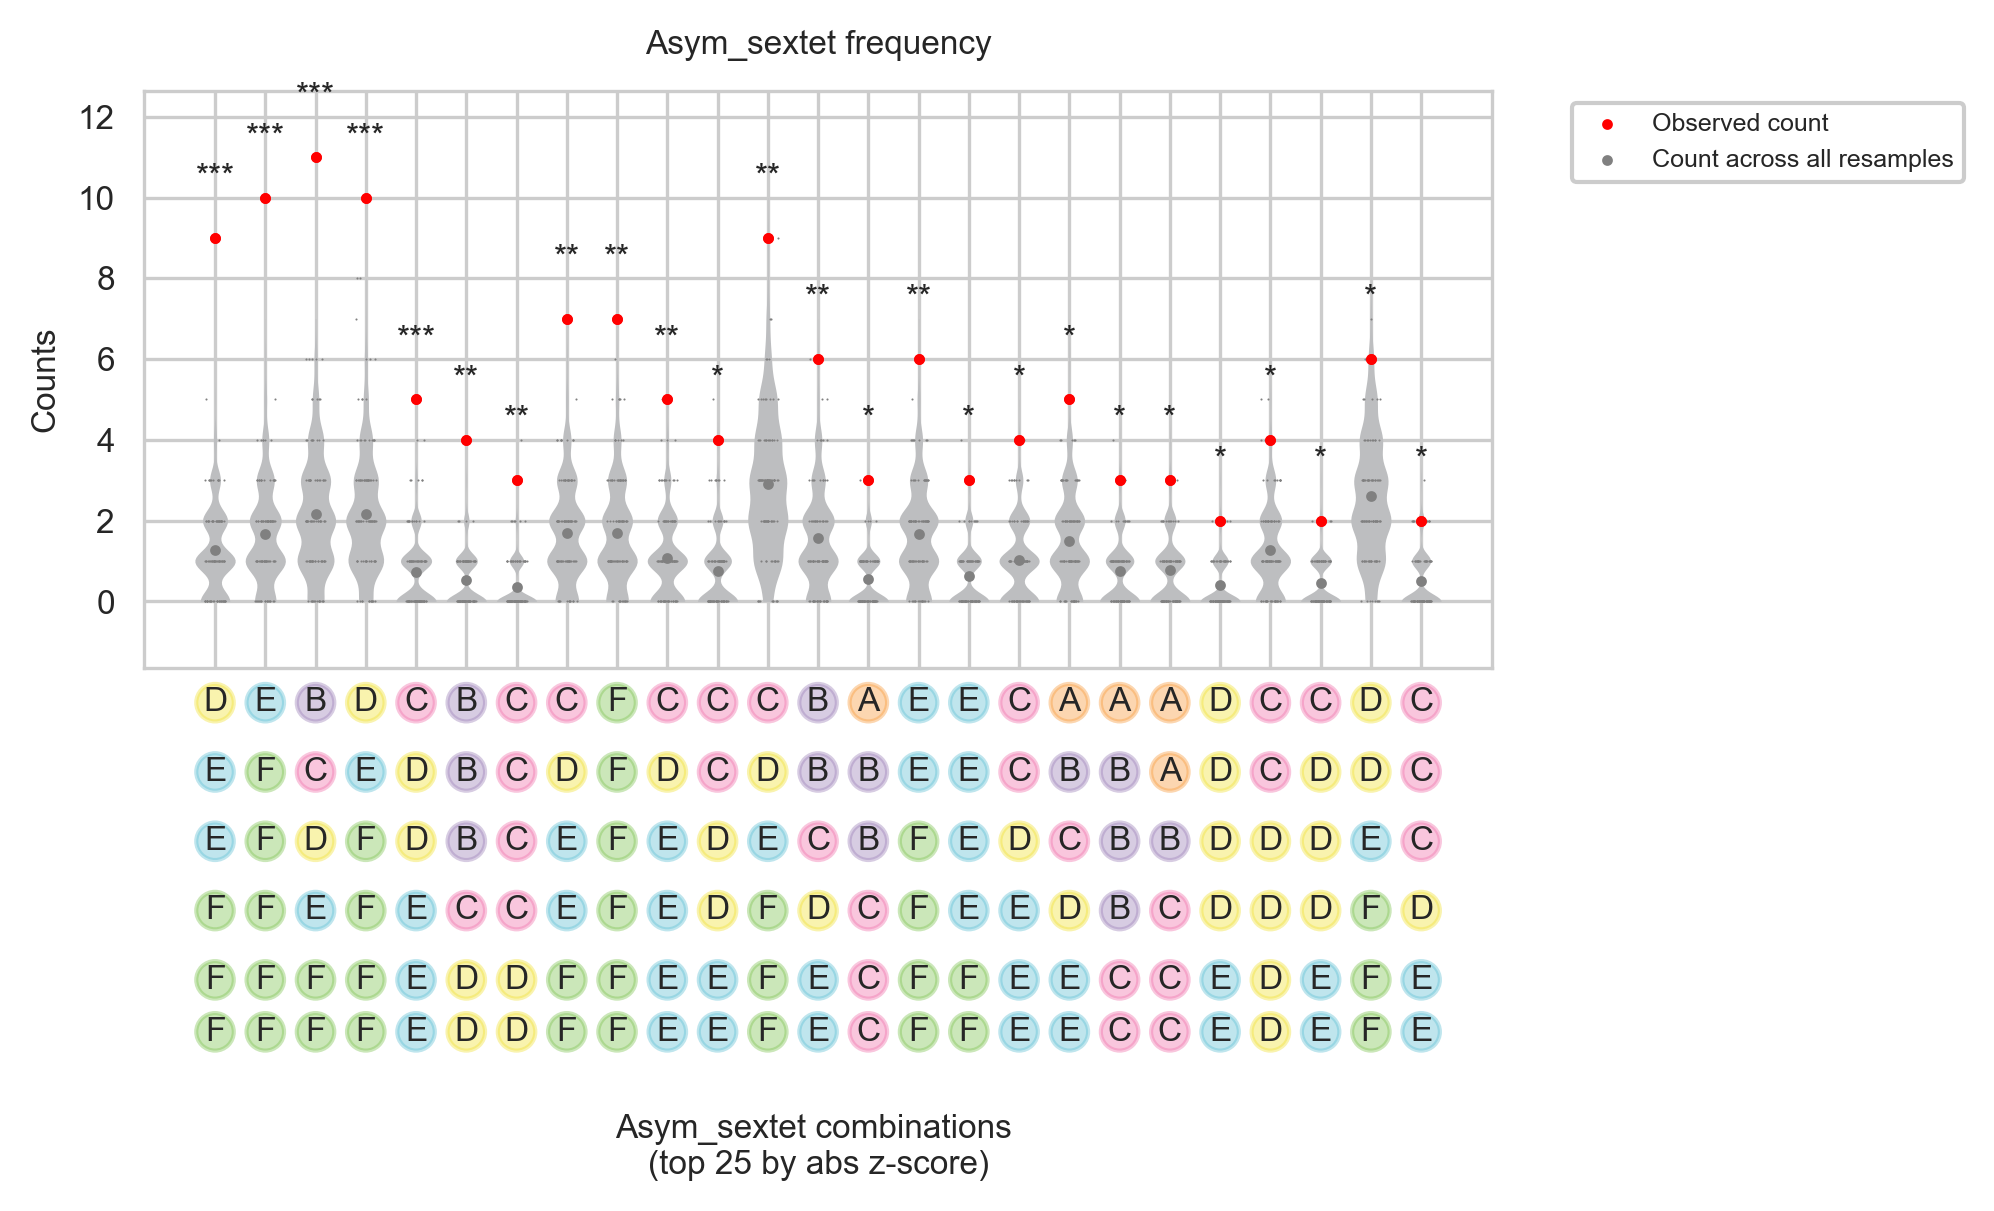

In [ ]:
plot_frequency('asym_sextet', 
                    df_true_melt_subset_asym_sextet, 
                    df_melt_subset_asym_sextet, 
                    df_melt_100resamples_subset_asym_sextet, 
                    cell_color_dict,
                    use_expected=False,
                    fdr_type='fdr_tsbh',
                    cutoff=40, 
                    title='auto',
                    multiple_datasets=False,
                    legend_bool=True, 
                    legend_pos='outside',
                    save=False, 
                    image_format='png',
                    dpi=300,
                    image_save_path=None)

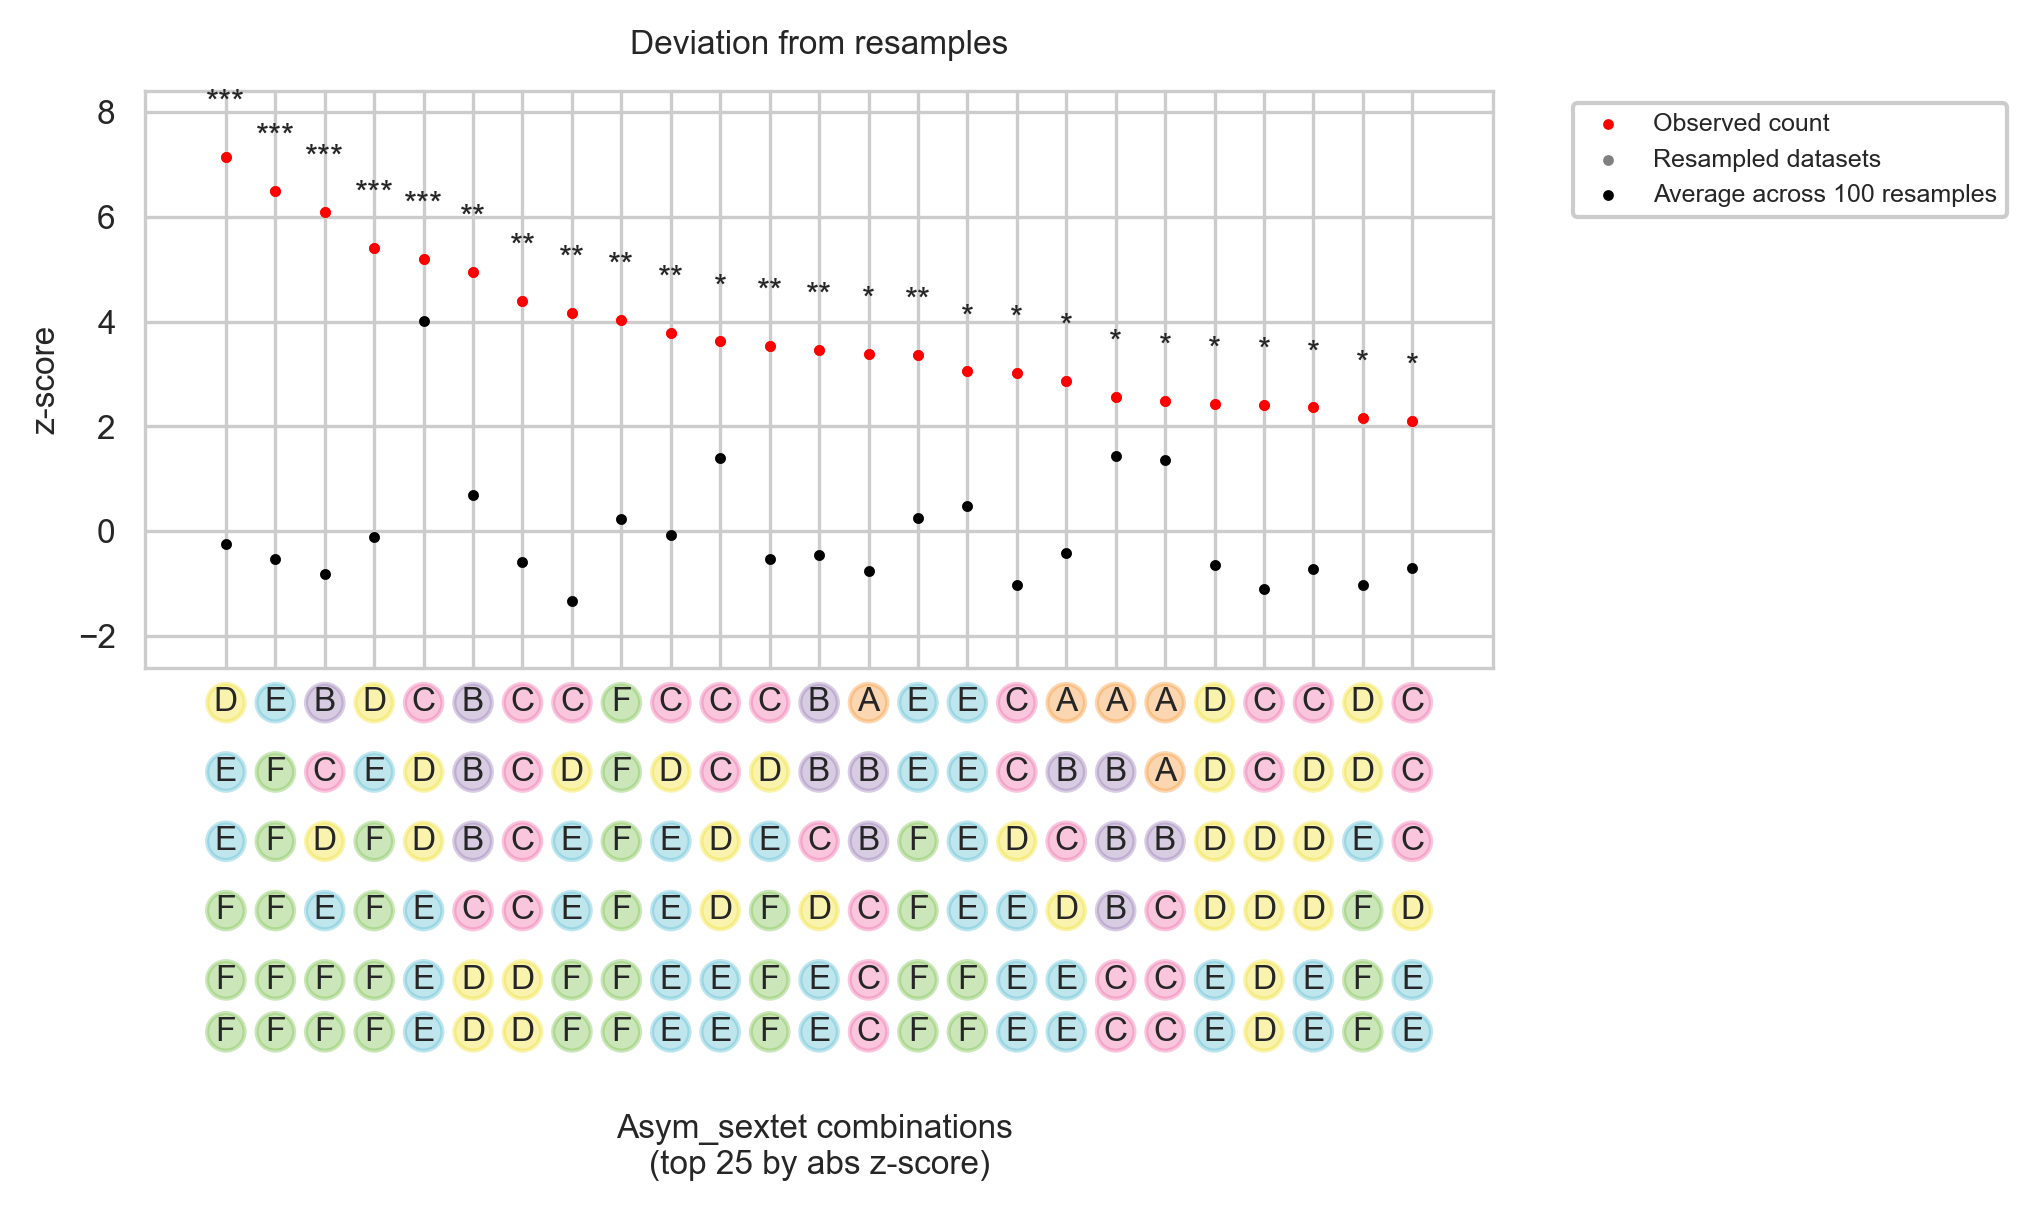

In [ ]:
plot_deviation('asym_sextet', 
                    df_true_melt_subset_asym_sextet, 
                    df_null_zscores_i_c_melt_subset_asym_sextet, 
                    df_null_zscores_i_c_melt_100resamples_subset_asym_sextet, 
                    cell_color_dict,
                    fdr_type='fdr_tsbh',
                    cutoff=40, 
                    title='auto',
                    multiple_datasets=False,
                    num_null=100,
                    legend_bool=True,
                    legend_pos='outside',
                    save=False, 
                    image_format='svg',
                    dpi=300,
                    image_save_path='comp_prog_dev_asym_sextet_v02')

In [ ]:
(asym_septet_dict, 
 cell_fates, 
 dfs_c_asym_septet) = resample_trees_asym_septets(all_trees_sorted, 
                                           num_resamples=1000, 
                                           replacement_bool=True, 
                                           cell_fates='auto',
                                           calc_expected=False
                                           )

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/163296 [00:00<?, ?it/s]

In [ ]:
(df_true_melt_subset_asym_septet, 
 df_melt_subset_asym_septet, 
 df_melt_100resamples_subset_asym_septet, 
 df_null_zscores_i_c_melt_subset_asym_septet, 
 df_null_zscores_i_c_melt_100resamples_subset_asym_septet) = dfs_for_plotting(dfs_c_asym_septet, 
                                                                       1000, 
                                                                       asym_septet_dict, 
                                                                       cutoff=25, 
                                                                       num_null=1,
                                                                       use_expected=False)

  0%|          | 0/163296 [00:00<?, ?it/s]

KeyboardInterrupt: 

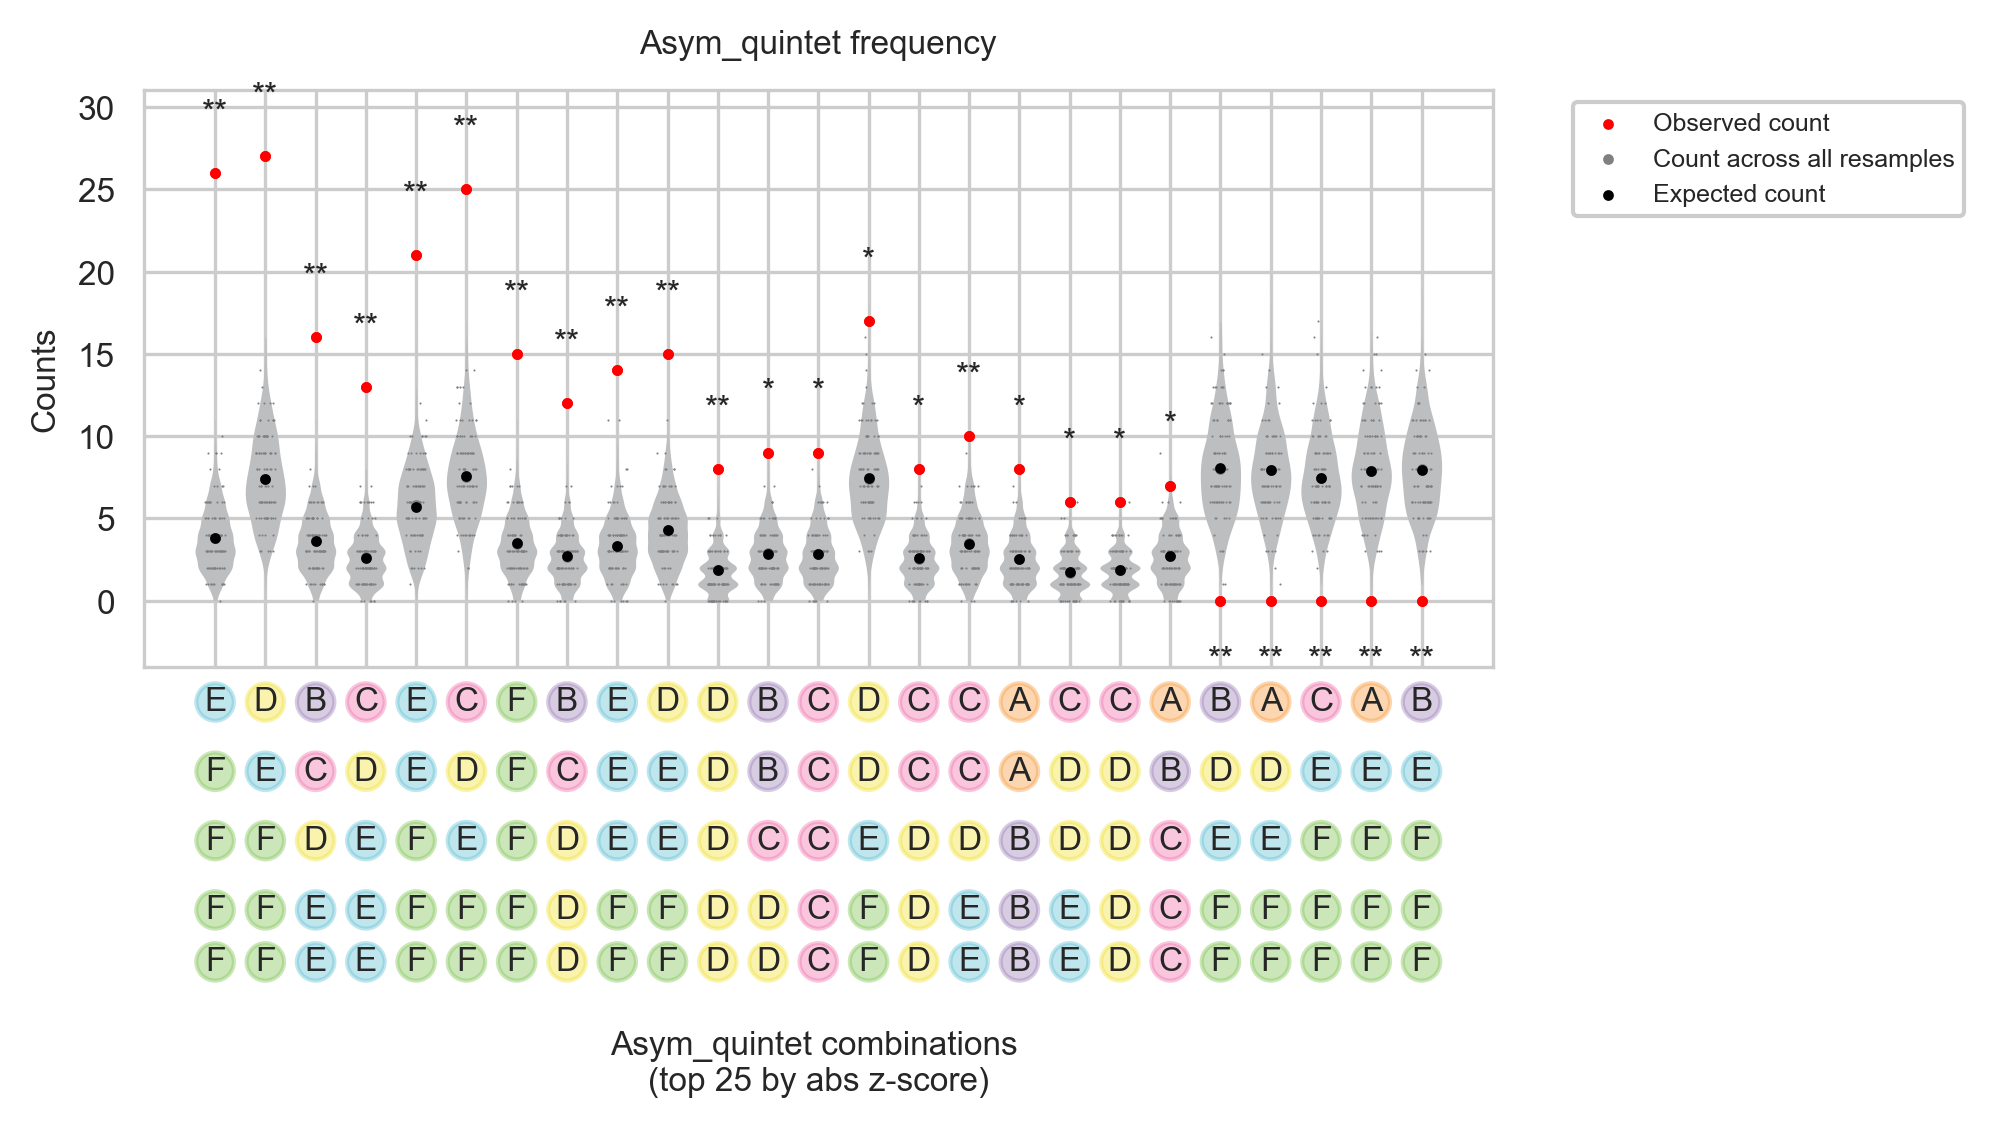

In [ ]:
plot_frequency('asym_septet', 
                    df_true_melt_subset_asym_septet, 
                    df_melt_subset_asym_septet, 
                    df_melt_100resamples_subset_asym_septet, 
                    cell_color_dict,
                    use_expected=False,
                    fdr_type='fdr_tsbh',
                    cutoff=40, 
                    title='auto',
                    multiple_datasets=False,
                    legend_bool=True, 
                    legend_pos='outside',
                    save=False, 
                    image_format='png',
                    dpi=300,
                    image_save_path=None)

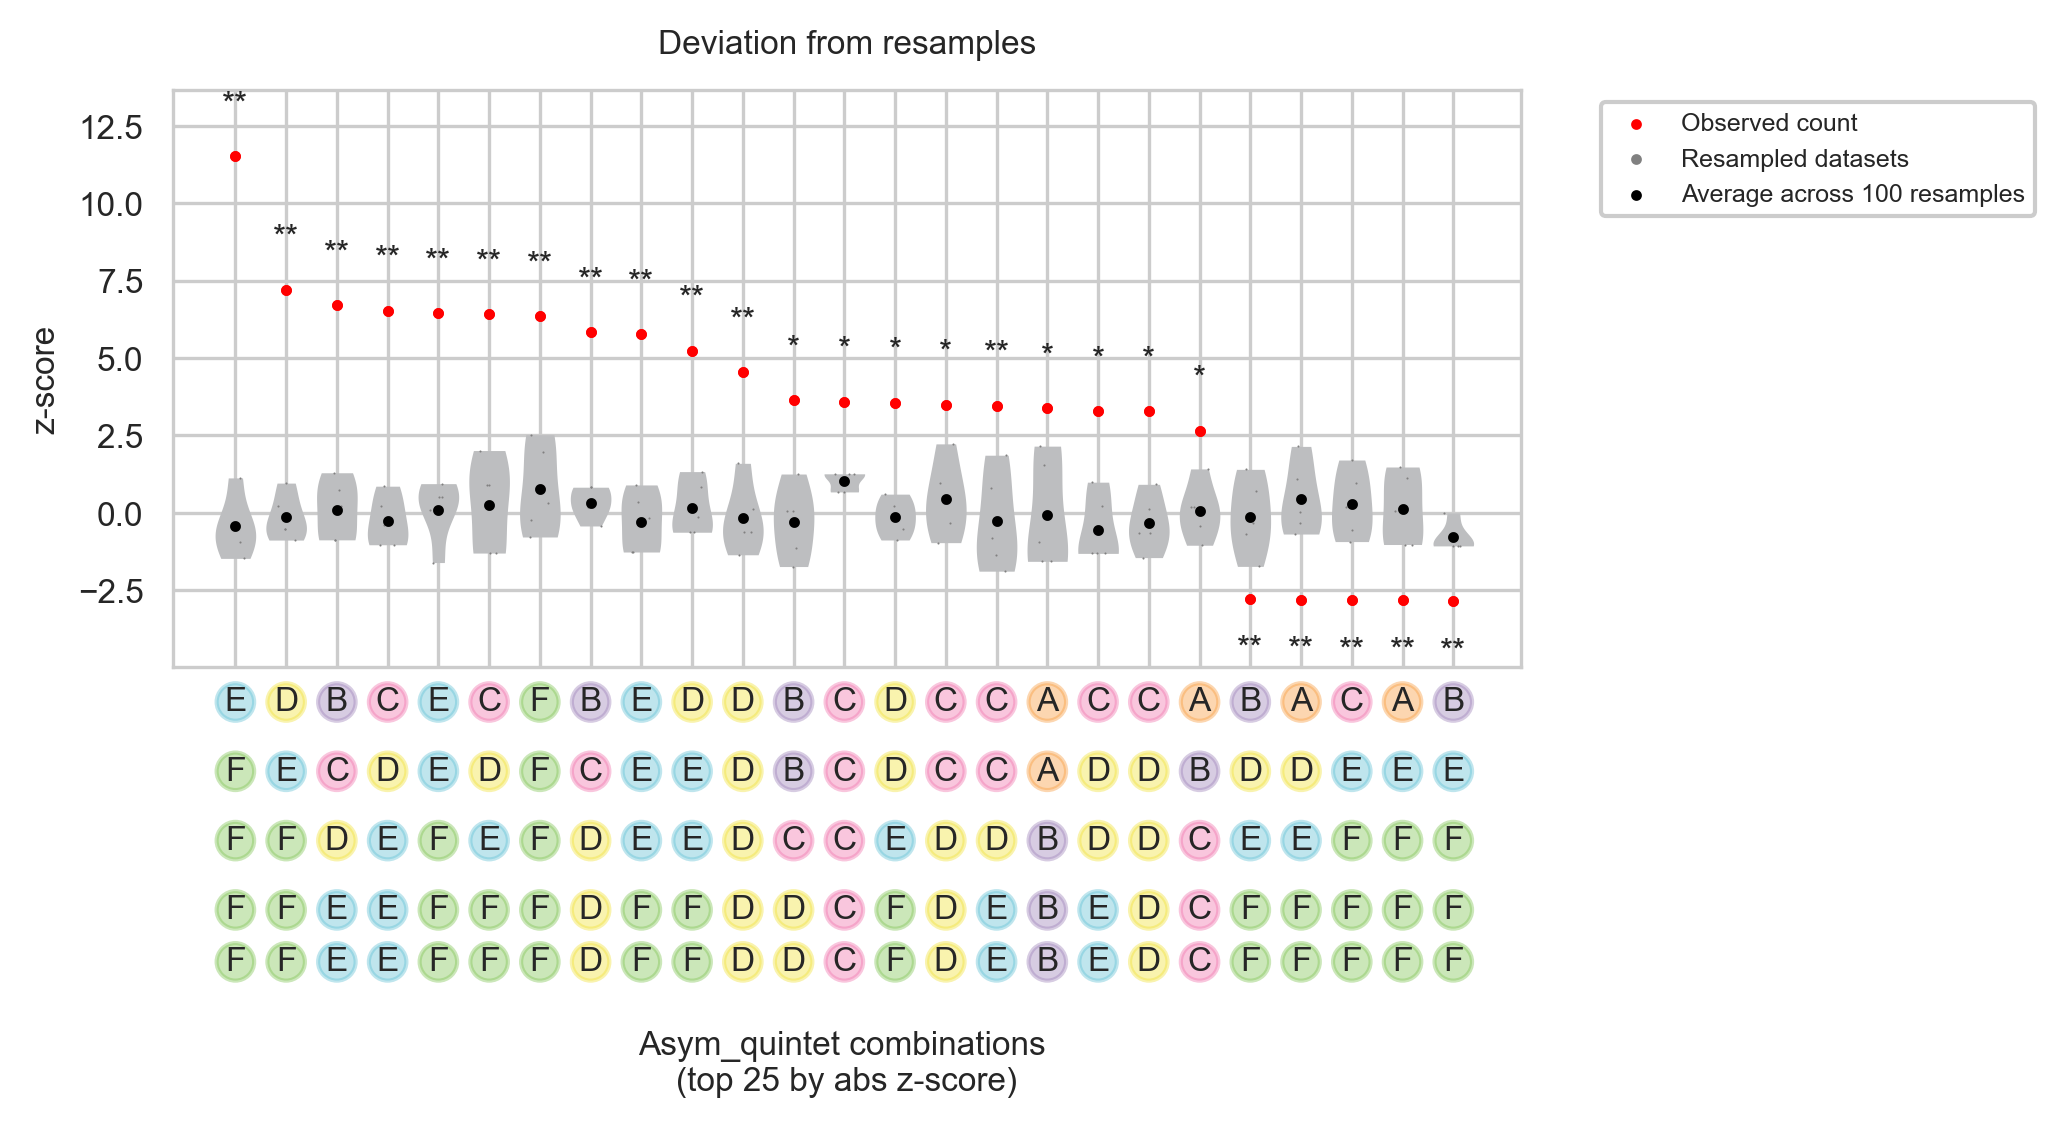

In [ ]:
plot_deviation('asym_septet', 
                    df_true_melt_subset_asym_septet, 
                    df_null_zscores_i_c_melt_subset_asym_septet, 
                    df_null_zscores_i_c_melt_100resamples_subset_asym_septet, 
                    cell_color_dict,
                    fdr_type='fdr_tsbh',
                    cutoff=40, 
                    title='auto',
                    multiple_datasets=False,
                    num_null=100,
                    legend_bool=True,
                    legend_pos='outside',
                    save=False, 
                    image_format='svg',
                    dpi=300,
                    image_save_path='comp_prog_dev_asym_septet_v02')